<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final Project - Programming for Data Science @ FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #FFCCCC; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 03 - Answering Question 📈
</div>

## Table of Contents

1. [**Import**](#import)  
2. [**Question 01: Which topics are most common?**](#question-01-which-topics-are-most-common)
3. [**Question 02: How do the topics associated with repositories correlate with their popularity?**](#question-02-how-do-the-topics-associated-with-repositories-correlate-with-their-popularity)
4. [**Question 03: Does age of a repository affect its popularity?**](#question-03-does-age-of-a-repository-affect-its-popularity)
5. [**Question 04: Are git repositories more popular if they have a homepage?**](#question-04-are-git-repositories-more-popular-if-they-have-a-homepage)

## Import

In [19]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats

## Read clean data from file

In [20]:
df = pd.read_csv('../Data/processed/data_processed.csv')
df.head()

,Name,Description,URL,Created At,Updated At,Homepage,Size,Stars,Forks,Issues,...,Topics,Has Issues,Has Projects,Has Downloads,Has Wiki,Has Pages,Has Discussions,Is Archived,Is Template,Default Branch
0,freeCodeCamp,freeCodeCamp.org's open-source codebase and cu...,https://github.com/freeCodeCamp/freeCodeCamp,2014-12-24 17:49:19+00:00,2023-09-21 11:32:33+00:00,http://contribute.freecodecamp.org/,387451,374074,33599,248,...,"['careers', 'certification', 'community', 'cur...",True,True,True,False,True,False,False,False,main
1,free-programming-books,:books: Freely available programming books,https://github.com/EbookFoundation/free-progra...,2013-10-11 06:50:37+00:00,2023-09-21 11:09:25+00:00,https://ebookfoundation.github.io/free-program...,17087,298393,57194,46,...,"['books', 'education', 'hacktoberfest', 'list'...",True,False,True,False,True,False,False,False,main
2,awesome,😎 Awesome lists about all kinds of interesting...,https://github.com/sindresorhus/awesome,2014-07-11 13:42:37+00:00,2023-09-21 11:18:22+00:00,(noHomepage),1441,269997,26485,61,...,"['awesome', 'awesome-list', 'lists', 'resource...",True,False,True,False,True,False,False,False,main
3,996.ICU,Repo for counting stars and contributing. Pres...,https://github.com/996icu/996.ICU,2019-03-26 07:31:14+00:00,2023-09-21 08:09:01+00:00,https://996.icu,187799,267901,21497,16712,...,[],False,False,True,False,False,False,True,False,master
4,coding-interview-university,A complete computer science study plan to beco...,https://github.com/jwasham/coding-interview-un...,2016-06-06 02:34:12+00:00,2023-09-21 10:54:48+00:00,(noHomepage),20998,265161,69434,56,...,"['algorithm', 'algorithms', 'coding-interview'...",True,False,True,False,False,False,False,False,main


## **Question 01: Which topics are most common ?**
- **Answering this question will** provide a clear understanding of the most common topics in our dataset, allowing us to identify prevalent themes or subjects among the repositories.
- **How we answer this question**: we'll categorize the dataset using interaction level labels determined by `Popularity Score`: `low` for repositories with minimal population, `medium` for those with average, and `high` for those with substantial population. Then, we'll identify topics that frequently appear in videos categorized as `high`.

### Pre-processing (Optional)

Check the `Topics` columns.

In [21]:
df['Topics']

0         ['careers', 'certification', 'community', 'cur...
1         ['books', 'education', 'hacktoberfest', 'list'...
2         ['awesome', 'awesome-list', 'lists', 'resource...
3                                                        []
4         ['algorithm', 'algorithms', 'coding-interview'...
                                ...                        
215024                                                   []
215025                                                   []
215026                                                   []
215027                                                   []
215028                                                   []
Name: Topics, Length: 215029, dtype: object

As we can see, the `Topics` column has a "special" data storage format: it is a `str` but has a structure similar to a `list` containing `str` elements inside. This can be "confusing" for reader, so we will change the format of the `Topics` string as follows: "`str_1|str_2[...]`". By the way, we will also remove the empty value in `Topics` columns.

In [22]:
# convert into format 'a|b|c..'
df['Topics'] = df['Topics'].apply(lambda x: '|'.join(x.strip("[]").replace("\'", "").split(', ')) if isinstance(x, str) else x)
# remove empty value
cop_data = df[df['Topics']!='']

cop_data['Topics'].sample(5)

176060                               emacs|getpocket|pocket
93373                                      database|rocksdb
133926    aop|caching-library|cfml|coldfusion|dependency...
5218      adblock|adguardhome|dnsmasq|easylist|neohosts|...
23196     dash|drm|hds|hls|livestream|mp4|mss|nginx|stre...
Name: Topics, dtype: object

### Analyzing to get the answer

Here, we will calculate the `Popularity Score` for each repository based on `Stars`, `Watchers` and `Forks`.

In [23]:
# assign weights to each metric
weight_stars = 0.4
weight_watchers = 0.3
weight_forks = 0.3

# calculate an overall popularity score using weighted sum
cop_data.loc[:,'Popularity_Score'] = (
    cop_data['Stars'] * weight_stars +
    cop_data['Watchers'] * weight_watchers +
    cop_data['Forks'] * weight_forks
)

cop_data['Popularity_Score'].describe()

C:\Users\HP\AppData\Local\Temp\ipykernel_13912\2165895958.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cop_data.loc[:,'Popularity_Score'] = (


count    113957.000000
mean       1068.075871
std        3805.078836
min         117.200000
25%         194.000000
50%         327.700000
75%         743.700000
max      271931.500000
Name: Popularity_Score, dtype: float64

Categorize the dataset using interaction level labels determined by `Popularity Score`

In [24]:
# extract topics from df
topics = cop_data['Topics'].str.split('|', expand=True)  # Splitting tags into separate columns

# add popularity_level category based on Popularity_Score
cop_data.loc[:,'popularity_level'] = pd.qcut(cop_data['Popularity_Score'], q=3, labels=['low', 'medium', 'high'])

# combine topics with popularity levels
topic_engagement = pd.concat([topics, cop_data['popularity_level']], axis=1)

# melt the DataFrame to have each topic in a separate row
melted = topic_engagement.melt(id_vars='popularity_level', value_vars=[0, 1, 2], value_name='Topics')

# count topic occurrences in each popularity level
topic_frequency = melted.groupby(['popularity_level', 'Topics'],observed=False).size().reset_index(name='frequency')

# extract rows where 'popularity_levels' is 'high'
high_engagement_topics = topic_frequency[topic_frequency['popularity_level'] == 'high']

# sort topics by frequency in descending order
sorted_high_topics = high_engagement_topics.sort_values(by='frequency', ascending=False)

sorted_high_topics.head(10)

C:\Users\HP\AppData\Local\Temp\ipykernel_13912\1385757660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cop_data.loc[:,'popularity_level'] = pd.qcut(cop_data['Popularity_Score'], q=3, labels=['low', 'medium', 'high'])


,popularity_level,Topics,frequency
119475,high,android,1919
149169,high,hacktoberfest,1459
153098,high,javascript,1352
137185,high,deep-learning,1071
165108,high,python,769
123662,high,awesome,748
147653,high,go,732
152965,high,java,688
147832,high,golang,678
123720,high,awesome-list,676


### Visualize the result

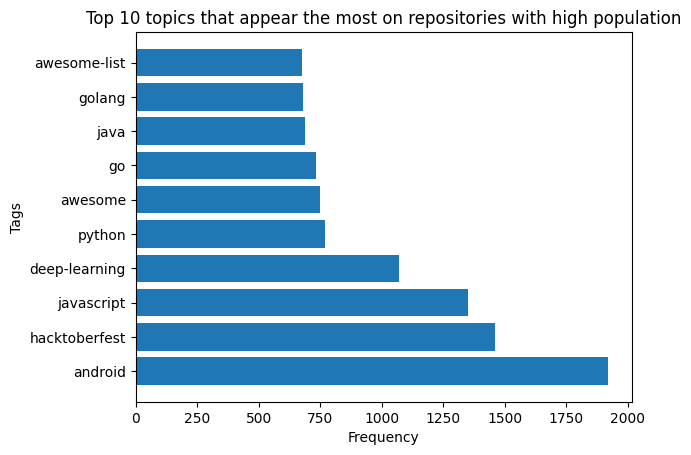

In [25]:
plt.barh(sorted_high_topics['Topics'].head(10),sorted_high_topics['frequency'].head(10))
plt.title('Top 10 topics that appear the most on repositories with high population')
plt.xlabel('Frequency')
plt.ylabel('Tags');

- **Conclusion**:
    - These topics are considered important and influential within the open-source software community on GitHub, given the high number of repositories and interactions associated with them.

## **Question 02: How do the topics associated with repositories correlate with their popularity?**
- **Answering this question will** help us reveal which topics tend to be more correlated with higher popularity metrics, offering insights into the relationship between repository content and their perceived popularity among users.
- **How we answer this question**: we will convert the top 10 topics into a numerical format suitable for analysis, then compute the correlation coefficients between each topic and the popularity metric (`Stars`,`Forks`,`Watchers`)

### Pre-processing (Optional)

### Analyzing to get the answer

We will specified the `top 10 most common topics`, encoding it and then calculate the `correlation matrix` between each topic in top 10 and Stars, Forks, Watchers.

In [26]:
# select top 10 most common topics
top_10_topics = sorted_high_topics.head(10)
# reverse from list of topics to dummy variables
topics = top_10_topics['Topics'].str.get_dummies(sep='|')
# combine dummy variables with original data and columns 'Stars', 'Forks', 'Watchers'
repos_with_topics = pd.concat([df[['Stars', 'Forks', 'Watchers']], topics], axis=1)
# calculate the correlation between dummy variables and columns 'Stars', 'Forks', 'Watchers'
correlation_matrix = repos_with_topics.corr()
# choose the relevant columns only
relevant_columns = correlation_matrix[['Stars', 'Forks', 'Watchers']]

### Visualize the result

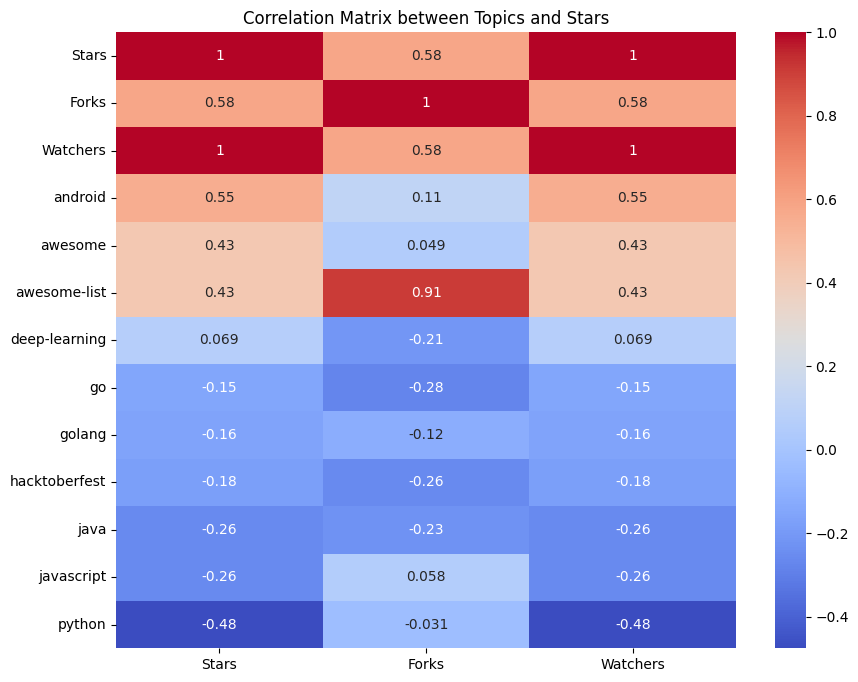

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(relevant_columns, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix between Topics and Stars');

- **Conclusion**: 
    - We can see that the topics 'android', 'awesome', and 'deep-learning' all exhibit a strong positive correlation with 'Stars' and 'Watchers'. Regarding 'Forks', there's a positive correlation with 'android', 'awesome', and 'hacktoberfest'.
    - It's evident that 'android' and 'awesome' topics hold substantial correlations across these three factors, while other topics show relatively weaker associations, this may indicate the importance of these topics for the attraction and interaction of the user community.

## **Question 03: Does age of a repository affect its popularity?**
- **This question will help** determine if new repositories can have a fair chance of earning stars or not.
- **We'll examine this question by**
    - Calculating the age of all repositories (in days).
    - Plotting age against the number of forks and stars of a repository.
    - Calculate and draw the correlation heatmap.

### Pre-processing (Optional)

In [28]:
df['Created At'] = pd.to_datetime(df['Created At'])

### Analyzing to get the answer

Calculate `age`

In [29]:
age = pd.Timestamp.now().date() - df['Created At'].dt.date
age = pd.to_timedelta(age,unit='d')
age = age.dt.days
age

0         3290
1         3729
2         3456
3         1737
4         2760
          ... 
215024    4952
215025    3327
215026    3432
215027    3803
215028    2655
Name: Created At, Length: 215029, dtype: int64

In [30]:
df['Age_(days)'] = age

### Plotting age against Stars and Forks

[Text(0.5, 1.0, 'Age - Forks relationship'),
 Text(0, 0.5, 'Forks'),
 Text(0.5, 0, 'Age (days)')]

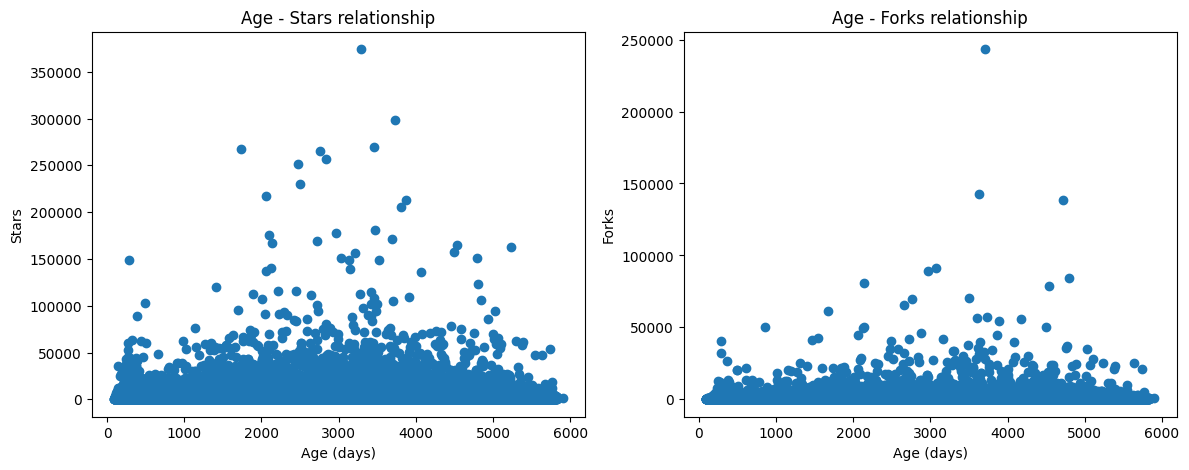

In [31]:
fig = plt.figure(figsize=(14,5))
axs = fig.subplots(1,2).flatten()

axs[0].scatter(y=df['Stars'], x=df['Age_(days)'])
axs[0].set(title='Age - Stars relationship', ylabel='Stars', xlabel='Age (days)')

axs[1].scatter(y=df['Forks'], x=df['Age_(days)'])
axs[1].set(title='Age - Forks relationship', ylabel='Forks', xlabel='Age (days)')

- We see that there is a very even distribution across all age values.

### Correlation heatmap

In [32]:
corr_matrix = np.corrcoef(df['Age_(days)'], [df['Stars'], df['Forks']])

Text(0.5, 1.0, 'Correlation matrix between age and stars/forks')

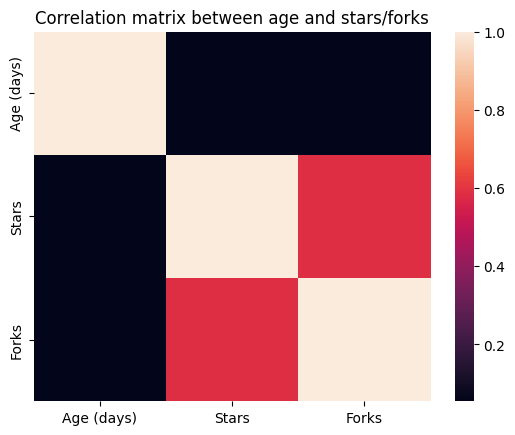

In [33]:
cols = ['Age (days)','Stars','Forks']
sns.heatmap(corr_matrix, xticklabels=cols, yticklabels=cols)
plt.title('Correlation matrix between age and stars/forks')

**Conclusion**
- So, there is virtually **no correlation** between age of a repository and its popularity.
- This means any repository can have fair chance of being popular, despite their age.

## **Question 04: Are git repositories more popular if they have a homepage?**
- **This question will help us** know whether repositories should create an additional homepage for users to navigate to.
- **We'll answer this question by**
    - Seperate the dataset into two sets: repositories that have homepages and those that don't.
    - Perform ANOVA-test between the amount of stars/forks of the two sets.
    - Plot boxplots to observe the distribution.

### Pre-processing (Optional)

Create `Has_Homepage` column

In [34]:
df['Has_Homepage'] = np.where(df['Homepage'] != '(noHomepage)', True, False)

### Analyzing to get the answer

Perform ANOVA test on the data
- An ANOVA test between two datasets $A$ and $B$ proposes the **null hypothesis** that the population means of the datasets are statistically expected to be equal.
- **Alternative hypothesis**: The population means of the datasets are statistically different.

In [35]:
stars_anovatest = stats.f_oneway(df[df['Has_Homepage'] == True]['Stars'], df[df['Has_Homepage'] == False]['Stars'], )
forks_anovatest = stats.f_oneway(df[df['Has_Homepage'] == True]['Forks'], df[df['Has_Homepage'] == False]['Forks'])

print('p-value of ANOVA test for Stars:', stars_anovatest.pvalue)
print('p-value of ANOVA test for Forks:', forks_anovatest.pvalue)

p-value of ANOVA test for Stars: 0.0
p-value of ANOVA test for Forks: 4.367229884044468e-143


The p-values are extremely small, so we can **reject the null hypothesis.**  
So, according to ANOVA test, the two data sets have **different** stars/forks mean.

### Plotting

**Note:** Because the distribution of forks and stars are heavily skewed, it is very hard to visualize these attributes normally. So, we'll apply **log-scaling** before visualization.

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Forks')

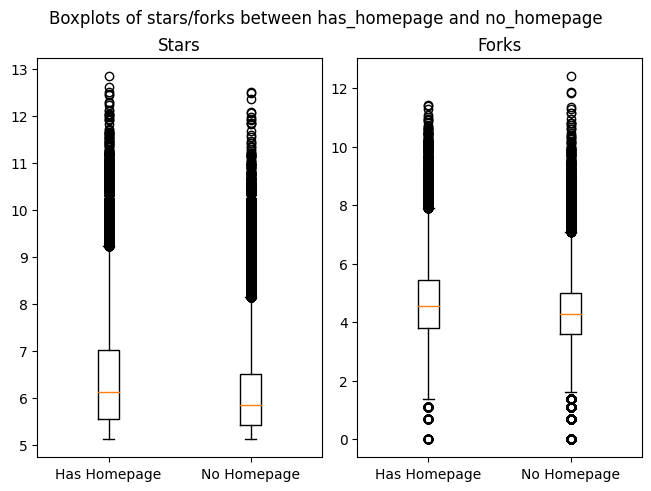

In [36]:
fig = plt.figure(layout='constrained')
fig.suptitle('Boxplots of stars/forks between has_homepage and no_homepage')
axs = fig.subplots(1,2)

axs[0].boxplot([np.log(df[df['Has_Homepage'] == True]['Stars']), np.log(df[df['Has_Homepage'] == False]['Stars'])], labels=['Has Homepage', 'No Homepage'])
axs[0].set_title('Stars')
axs[1].boxplot([np.log(df[df['Has_Homepage'] == True]['Forks']), np.log(df[df['Has_Homepage'] == False]['Forks'])], labels=['Has Homepage', 'No Homepage'])
axs[1].set_title('Forks')

**Conclusion:**
- From the boxplots and ANOVA tests, we can see that repositories with a homepage are likely to gain more stars and forks than repositories that don't have a homepage.
- This can be an incentive for repositories wanting to be popular to add a homepage.